# Imports

In [1]:
import datetime
import string
import math
import os
import re

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import keras
import numpy as np

from faker import Faker

assert tf.test.is_gpu_available(), 'No GPU is available.'

2024-03-13 17:07:15.939099: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 17:07:15.939146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 17:07:15.940183: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 17:07:15.946048: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 17:07:16.905561: W tensorflow/compiler/tf2

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-03-13 17:07:18.344462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-13 17:07:18.453992: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-13 17:07:18.454517: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
keras.__version__

'3.0.5'

In [3]:
import keras_ocr

# Data loading

In [4]:
russian_chars = 'АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя'
data_dir = '.'
alphabet = russian_chars+ '!?. '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)
len(backgrounds)

Looking for ./backgrounds.zip


1034

In [5]:
all_fonts = []
for address, dirs, files in os.walk('r_fonts'):
    for file in files:
        if file.endswith('.ttf') or file.endswith('.otf'):
            all_fonts.append(os.path.join(address, file))
            
base_fonts = []
for address, dirs, files in os.walk('r_fonts1'):
    for file in files:
        if file.endswith('.ttf') or file.endswith('.otf'):
            base_fonts.append(os.path.join(address, file))
            
fonts = all_fonts + base_fonts*((len(backgrounds)-len(all_fonts))//len(base_fonts))
len(all_fonts), len(base_fonts), len(fonts)

(416, 11, 1032)

In [6]:
def text_generator():
    while True:
        yield Faker(['ru']).sentence()

print(f'The first generated text is:', next(text_generator()))

The first generated text is: Полностью художественный хлеб.


The first generated validation image (below) contains:
 Скры
тый н
абор
прис


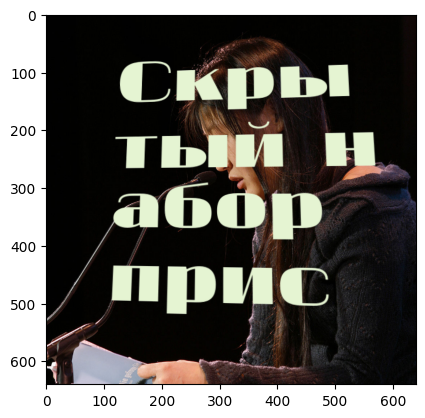

In [7]:
def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator(),
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:\n', text)
plt.imshow(image)

# Config

In [8]:
input_shape = (32,128)

recognizer_batch_size = 64
bos_token = '<'
eos_token = '>'

patch_size = 16
num_patches = input_shape[0]//patch_size * input_shape[1]//patch_size
projection_dim = 768

attention_heads = 12
intermediate_dim = 3072

sequence_length = input_shape[0]//patch_size * input_shape[1]//patch_size + 1

In [9]:
sequence_length

17

# Utils

## Vectorization

In [10]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")


vector_alphabet = [bos_token, eos_token] + list(recognizer_alphabet)



def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

def custom_split(input_string):
    split = tf.strings.unicode_split(input_string, 'UTF-8')

    if len(split.shape) <2:
        split = tf.expand_dims(split, 0)
        
    # print(split.shape)
    
    starts = tf.constant(['[bos]']*split.shape[0], dtype=tf.string)
    starts = tf.reshape(starts, [split.shape[0], 1])
    
    ends = tf.constant(['[eos]']*split.shape[0], dtype=tf.string)
    ends = tf.reshape(ends, [split.shape[0], 1])
    
    split = tf.concat([starts, split, ends], axis=1)

    return split

vectorization = keras.layers.TextVectorization(
    output_mode="int",
    output_sequence_length=sequence_length,
    vocabulary=vector_alphabet,
    split='character',
    standardize='lower',
    ngrams=None
)

2024-03-13 17:07:29.418111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-13 17:07:29.418480: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-13 17:07:29.418720: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
vectorization('<тест сплита строки>'), len('Тест сплита строки')

(<tf.Tensor: shape=(17,), dtype=int64, numpy=array([ 2, 26, 13, 25, 26,  4, 25, 23, 19, 16, 26,  8,  4, 25, 26, 24, 22])>,
 18)

In [12]:
def convert_image_generator_to_recognizer_input(
    image_generator, max_string_length, target_width, target_height, margin=0
):
    """Convert an image generator created by get_image_generator
    to (image, sentence) tuples for training a recognizer.

    Args:
        image_generator: An image generator created by get_image_generator
        max_string_length: The maximum string length to allow
        target_width: The width to warp lines into
        target_height: The height to warp lines into
        margin: The margin to apply around a single line.
    """
    while True:
        image, lines = next(image_generator)
        if len(lines) == 0:
            continue
        for line in lines:
            line = keras_ocr.data_generation._strip_line(line[:max_string_length])
            if not line:
                continue
            box, sentence = keras_ocr.tools.combine_line(line)

            sentense = bos_token+sentence+eos_token
            
            # remove multiple sequential spaces
            while "  " in sentence:
                sentence = sentence.replace("  ", " ")            
            try:
                crop = keras_ocr.tools.warpBox(
                    image=image,
                    box=box,
                    target_width=target_width,
                    target_height=target_height,
                    margin=margin,
                    skip_rotate=True,
                )
            except:
                continue
            yield crop, sentence

In [13]:
recognition_image_generators = [
    convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length= sequence_length,
        target_width=input_shape[1],
        target_height=input_shape[0],
        margin=1
    ) for image_generator in image_generators
]

This image contains: Н


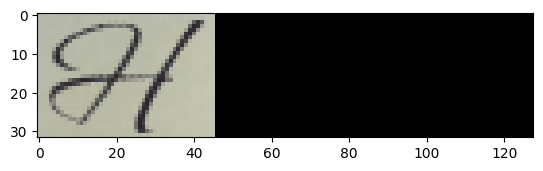

In [14]:
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

In [15]:
def get_generator_from_recognizer_input(generator, batch_size=recognizer_batch_size):
    while True:
        images = []
        texts = []
        for _ in range(batch_size): 
           image, text = next(generator)
           images.append(image/255)
           texts.append(text)
        texts = vectorization(texts)
        yield (
            {
                "encoder_inputs": tf.constant(images),
                "decoder_inputs": tf.constant(texts[:, :-1]),
            },
            tf.constant(texts[:, 1:]),
        )
test = next(get_generator_from_recognizer_input(recognition_image_generators[1]))

In [16]:
test

({'encoder_inputs': <tf.Tensor: shape=(64, 32, 128, 3), dtype=float64, numpy=
  array([[[[0.71764706, 0.7254902 , 0.6745098 ],
           [0.71764706, 0.7254902 , 0.6745098 ],
           [0.71372549, 0.72156863, 0.67058824],
           ...,
           [0.72941176, 0.72941176, 0.63529412],
           [0.7372549 , 0.7372549 , 0.64313725],
           [0.7372549 , 0.7372549 , 0.64313725]],
  
          [[0.71764706, 0.72156863, 0.67058824],
           [0.72156863, 0.72941176, 0.6745098 ],
           [0.72156863, 0.72941176, 0.6745098 ],
           ...,
           [0.72941176, 0.72941176, 0.63529412],
           [0.7372549 , 0.7372549 , 0.64313725],
           [0.7372549 , 0.7372549 , 0.64313725]],
  
          [[0.71764706, 0.7254902 , 0.67058824],
           [0.72156863, 0.72941176, 0.6745098 ],
           [0.72156863, 0.72941176, 0.6745098 ],
           ...,
           [0.72941176, 0.72941176, 0.63921569],
           [0.7372549 , 0.7372549 , 0.64313725],
           [0.7372549 , 0.7372549

In [17]:
(test[1]).shape, test[0]['encoder_inputs'].shape,  test[0]['decoder_inputs'].shape, 

(TensorShape([64, 16]), TensorShape([64, 32, 128, 3]), TensorShape([64, 16]))

In [18]:
class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = keras.layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = inputs.shape[-1]
        positions =tf.range(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return tf.ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [19]:
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        # print(input_shape)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        # print(images, [1, self.patch_size, self.patch_size,1], [1, self.patch_size, self.patch_size, 1])
        patches = tf.image.extract_patches(images, 
                                           sizes=[1, self.patch_size, self.patch_size,1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        patches = tf.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config
    
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.cls_embedding = keras.layers.Dense(
            projection_dim, activation='linear'
        )

    def call(self, patch):
        positions = tf.expand_dims(
            tf.range(start=0, limit=self.num_patches+1, delta=1), axis=0
        )
        
        projected_patches = self.projection(patch)
        cls = self.cls_embedding(keras.layers.Flatten()(projected_patches))
        cls = tf.expand_dims(cls, axis=1)
        projected_patches = tf.concat([cls,projected_patches], axis=1)

        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [20]:
def convert_encoder_to_decoder(encoder, decoder_input_shape=(None,None, 768)):
    
    decoder = keras_nlp.layers.TransformerDecoder.from_config(encoder.get_config())
    decoder.build(encoder.output.shape, decoder_input_shape)
    
    decoder_weights = []
    
    for dw in decoder.weights:
        dp = '/'.join(dw.path.split('/'))
        # print(dw.shape, dp)
        for ew in encoder.weights:
            ep = '/'.join(ew.path.split('/'))
            if ep == dp:
                # print(ew.shape, ep)
                decoder_weights.append(ew.value)
                break
        else:
            decoder_weights.append(dw.value)
        #     print('Not found')
        # print('-------------')
    
    # for i in range(len(decoder_weights)):
    #     print(decoder_weights[i].shape, decoder.get_weights()[i].shape)
        

    
    decoder.set_weights(decoder_weights)  

    for w in decoder.weights:
        if not 'cross' in w.path:
            w.trainable = False
    
    return decoder

In [21]:
import keras_nlp

In [22]:
roberta = keras_nlp.models.RobertaBackbone.from_preset("roberta_base_en")
roberta.summary()

2024-03-13 17:08:02.899275: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154414080 exceeds 10% of free system memory.


Model: "roberta_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings          │ (None, None, 768) │ 38,996,736 │ token_ids[0][0]   │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_layer_n… │ (None, None, 768) │      1,536 │ embeddings[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_dropout  │ (None, None, 768) │          0 │ embeddings_layer… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_0 │ (None, None, 768) │  7,087,872 │ embeddings_dropo… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_1 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_2 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_3 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_4 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_5 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_6 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_7 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_8 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_9 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_… │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_… │ (None, None, 768) │  7,087,872 │ transformer_laye

 Total params: 124,052,736 (473.22 MB)

 Trainable params: 124,052,736 (473.22 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
roberta_backbone = keras.Sequential()
roberta_backbone.add(keras.Input(shape=(None, 768)))
for i in range(len(roberta.layers)):
    if i>4:
        l = roberta.layers[i]
        l.trainable = False
        roberta_backbone.add(l)
roberta_backbone.summary(), roberta_backbone.layers

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ transformer_layer_0             │ (None, None, 768)      │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_1             │ (None, None, 768)      │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_2             │ (None, None, 768)      │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_3             │ (None, None, 768)      │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_4             │ (None, None, 768)      │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_5             │ (None, None, 768)      │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_6             │ (None, None, 768)      │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_7             │ (None, None, 768)      │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_8             │ (None, None, 768)      │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_9             │ (None, None, 768)      │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_10            │ (None, None, 768)      │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_11            │ (None, None, 768)      │     7,087,872 │
│ (TransformerEncoder)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,054,464 (324.46 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 85,054,464 (324.46 MB)

(None,
 [<TransformerEncoder name=transformer_layer_0, built=True>,
  <TransformerEncoder name=transformer_layer_1, built=True>,
  <TransformerEncoder name=transformer_layer_2, built=True>,
  <TransformerEncoder name=transformer_layer_3, built=True>,
  <TransformerEncoder name=transformer_layer_4, built=True>,
  <TransformerEncoder name=transformer_layer_5, built=True>,
  <TransformerEncoder name=transformer_layer_6, built=True>,
  <TransformerEncoder name=transformer_layer_7, built=True>,
  <TransformerEncoder name=transformer_layer_8, built=True>,
  <TransformerEncoder name=transformer_layer_9, built=True>,
  <TransformerEncoder name=transformer_layer_10, built=True>,
  <TransformerEncoder name=transformer_layer_11, built=True>])

In [24]:
for i in range(len(roberta_backbone.layers)):
    l = roberta_backbone.layers[i]
    l1 = roberta.layers[i+5]
    print(l.weights[0].value - l1.weights[0].value)

tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]

In [28]:
def build_model(bert=roberta_backbone, vect=vectorization, num_pairs=2):

    encoder_inputs = keras.layers.Input(shape=input_shape+(3,)) 
    patches = Patches(patch_size)(encoder_inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=attention_heads)(encoded_patches)
    encoded = keras.layers.Dropout(0.1)(encoded)
    for _ in range(num_pairs-1):
        encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=attention_heads)(encoded)
        encoded = keras.layers.Dropout(0.1)(encoded)

    encoded_seq_inputs = keras.layers.Input(shape=(sequence_length, projection_dim), name="encoder output")


    decoder_inputs = keras.layers.Input(shape=(sequence_length-1,))
    decoder_inputs_embedded = keras.layers.Embedding(input_dim=1, output_dim=projection_dim)(decoder_inputs)

    print(decoder_inputs_embedded.shape, encoded_seq_inputs.shape)

    decoded = convert_encoder_to_decoder(bert.layers[0], (sequence_length-1,))(decoder_inputs,encoded_seq_inputs)
    decoded = keras.layers.Dropout(0.1)(decoded)
    for i in range(1, num_pairs):
        decoded = convert_encoder_to_decoder(bert.layers[i], (sequence_length-1,))(decoded, encoded_seq_inputs)
        decoded = keras.layers.Dropout(0.1)(decoded)
    
    
    logits = keras.layers.Dense(len(vect.get_vocabulary()), activation='softmax')(decoded)
    
    decoder = keras.Model(inputs=[decoder_inputs, encoded_seq_inputs],
                          outputs=logits,
                          name="TransformerDecoder")

    
    
    decoder_outputs = decoder([decoder_inputs, encoded])
  
    
    
    model = keras.Model(inputs={'encoder_inputs':encoder_inputs, 'decoder_inputs':decoder_inputs}, 
                        outputs=decoder_outputs)
    return model
TROCR = build_model()
TROCR.summary()

(None, 16, 768) (None, 17, 768)


2024-03-13 17:10:57.646663: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.00MiB (rounded to 9437184)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-13 17:10:57.646708: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-03-13 17:10:57.646719: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 119, Chunks in use: 119. 29.8KiB allocated for chunks. 29.8KiB in use in bin. 1.0KiB client-requested in use in bin.
2024-03-13 17:10:57.646728: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 17, Chunks in use: 17. 12.5KiB allocated for chunks. 12.5KiB in use in bin. 12.3KiB client-requested in use in bin.
2024-03-13 17:10:57.64673

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 

In [ ]:
TROCR.layers[-1].summary()

In [ ]:
TROCR.predict(test[0])

In [138]:
TROCR.compile(optimizer=keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-2), 
                    loss=keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['sparse_top_k_categorical_accuracy', 'sparse_categorical_accuracy'])

In [139]:
recognizer_basepath = os.path.join(data_dir, f'../checkpoints/recogniser_{datetime.datetime.now().isoformat()}')

class_weights = {i:1. for i in range(TROCR.output.shape[-1])}
class_weights[0]=10.
class_weights[2]=class_weights[3]=0.5

hist = {}
log_dir = "../logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# while True:
    
train_data_generator, val_data_generator, test_data_generator = [ 
    get_generator_from_recognizer_input(generator) for generator in recognition_image_generators
]
# try:
his = TROCR.fit(
    train_data_generator, epochs=10000,
    steps_per_epoch=math.ceil(len(background_splits[0]) / recognizer_batch_size)*10,

    callbacks=[tensorboard_callback,
    #tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=100, monitor='val_loss'),
    tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv'),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.keras'),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.99, cooldown=15, patience=10, min_lr=1e-5)
    ],
    validation_data=val_data_generator,
    validation_steps=math.ceil(len(background_splits[1]) / recognizer_batch_size),
    batch_size=recognizer_batch_size,
    # class_weight=class_weights
)
# except Exception as e:
#     print(e)
# else:
for key in his.history.keys():
    if hist.get(key) is not None:
        hist[key] += his.history[key]
    else:
        hist[key] = his.history[key]

Epoch 1/10000


ValueError: Exception encountered when calling EinsumDense.call().

[1mShape must be rank 1 but is rank 3
	 for 0th input and equation: a,abc->bc for '{{node functional_67_1/TransformerDecoder_1/transformer_layer_0_1/cross_attention_1/key_1/einsum/Einsum}} = Einsum[N=2, T=DT_FLOAT, equation="a,abc->bc"](functional_67_1/dropout_309_1/stateless_dropout/SelectV2, functional_67_1/TransformerDecoder_1/transformer_layer_0_1/cross_attention_1/key_1/Cast/ReadVariableOp)' with input shapes: [?,17,768], [16,16,12].[0m

Arguments received by EinsumDense.call():
  • inputs=tf.Tensor(shape=(None, 17, 768), dtype=float32)